In [1]:
# Activate environment.
# You do not need to do this if you are not using separate environment
push!(LOAD_PATH, "$(homedir())/pCloudDrive/julia_project")
using Pkg
Pkg.activate("/home/yusri/pCloudDrive/julia_project/MovingFrame/")


 Activating environment at `~/pCloudDrive/julia_project/MovingFrame/Project.toml`


In [2]:
using GeometryBasics
using FileIO
using LinearAlgebra;
using GaussianProcesses;
using PlutoUI
using MovingFrame;
import Plots;
const mva = MovingFrame
const plt = Plots

Plots

In [3]:
# Create MovingCells Type
struct MovingCells
    coordinates::Matrix{Float64}
    time::Vector{Float64}
    smooth_n_points::Int64
    smooth_coordinates::Matrix{Float64}
    smooth_time::Vector{Float64}
    T::Matrix{Float64}
    N::Matrix{Float64}
    B::Matrix{Float64}
    curvature::Vector{Float64}
    torsion::Vector{Float64}
    speed::Vector{Float64}
    original_shapes::Vector{GeometryBasics.Mesh}
    reoriented_shapes::Vector{GeometryBasics.Mesh}
    Spharm_Cx::Matrix{Float64}
    Spharm_Cy::Matrix{Float64}
    Spharm_Cz::Matrix{Float64}
end

In [4]:
const base_dir = pwd();
# You need to extract the cell_shape_final.zip first
const input_data_dir = joinpath(base_dir, "cell_shape_final/")
const input_files = readdir(input_data_dir);
const n_points = length(input_files)

250

In [5]:
# Calculating the cell trajectory
coordinate = Matrix{Float64}(undef, n_points, 3)
time = collect(1.0:n_points)
shapes = Vector{GeometryBasics.Mesh}(undef, n_points)
for i = 1:length(input_files)
    shape = load(joinpath(input_data_dir, input_files[i]))
    shapes[i] = shape
    verts = decompose(Point3f0, shape)
    # The trajectory is the mass centre of the cell
    coordinate[i, :] .= reduce(+, verts) / length(verts)
end
# Normalizing volume and translation
shapes = (volume_normalizing ∘ mesh_centering).(shapes)
new_coordinate = coordinate .- coordinate[1, :]';

In [6]:
exp_lengthscale = 3.4 # lengthscale = e^3.4
exp_variance= 0.0 #variance = e^0.0

# Gaussian Processs using Zero mean function and 
# Squared exponential kernel (note that hyperparameters are on the log scale)
smoother =  GaussianProcessSmoother(MeanZero(), SE(exp_lengthscale, exp_variance))
smooth_coordinates = smoothing(new_coordinate, smoother, step=1.)
smooth_time = range(1.0, stop=time[end], length=size(smooth_coordinates, 1)) |> collect
T, N, B, curvature, torsion, speed = parallel_transport(smooth_coordinates);

In [7]:
# Reoriented the cell shape to the Moving Frame basis

reoriented_shape = [
    mesh_reorientation(shapes[i], T[i, :], N[i, :], B[i, :])
    for i in eachindex(shapes)
];

In [8]:
# Spherical parameterization

spheres = MovingFrame.spherization.(reoriented_shape, n_step=100);


In [9]:
# Calculating spherical harmonics coefficients
spharm_coefs = [
    MovingFrame.spharm_descriptor(
        reoriented_shape[i],
        GeometryBasics.coordinates(spheres[i]),
    ) for i in eachindex(reoriented_shape)
]
Cx = MovingFrame.array_of_array_to_matrix([coef[:Cx] for coef in spharm_coefs])
Cy = MovingFrame.array_of_array_to_matrix([coef[:Cy] for coef in spharm_coefs])
Cz = MovingFrame.array_of_array_to_matrix([coef[:Cz] for coef in spharm_coefs])

250×49 Array{Float64,2}:
  0.00237336    0.00685443  1.2802   …  -0.000634279  -0.00167789
  0.00561731    0.0104734   1.28594     -0.00236576   -0.0035264
  0.0130635     0.00960054  1.28695     -0.0104202     0.000228702
  0.0188848     0.00295399  1.27806     -0.00319549    0.00310279
  0.0220791    -0.00470741  1.27058      0.00529956   -0.00223282
  0.0243114    -0.011366    1.26637  …   0.00936769   -0.00835933
  0.0261101    -0.016967    1.26372      0.0104154    -0.012858
  0.0274683    -0.0214808   1.26145      0.0103427    -0.0158479
  0.0282029    -0.0243929   1.25911      0.00978892   -0.0178524
  0.0280974    -0.0250202   1.25689      0.0087535    -0.0192933
  0.0268853    -0.0232832   1.25512  …   0.0070805    -0.0199014
  0.0246729    -0.0209504   1.25248      0.00587148   -0.0188138
  0.0221393    -0.0205413   1.24915      0.00638564   -0.0158076
  ⋮                                  ⋱                
 -0.00759151    0.0205943   1.16866      0.0336265    -0.0054327
 -0.0

In [10]:
xy_ecc = Cx[:, 4] ./ Cy[:, 2]
xz_ecc = Cx[:, 4] ./ Cz[:, 3]
yz_ecc = Cy[:, 2] ./ Cz[:, 3]

250-element Array{Float64,1}:
 0.9852945697558535
 0.9769310374307966
 0.9725653917021942
 0.9767211473384777
 0.9801465610267861
 0.9810047883797197
 0.9806823952263585
 0.9803156948124984
 0.9805948216612108
 0.9813995339349907
 0.982064996470878
 0.9837812107999642
 0.9856839611000301
 ⋮
 0.9547204744977613
 0.955122732934125
 0.9560337449764954
 0.9574331780449782
 0.9592913447614672
 0.9615850399251703
 0.9643281759443874
 0.9674552016807858
 0.9709027395607327
 0.9744794046410271
 0.9780007636381245
 0.9815370486944749

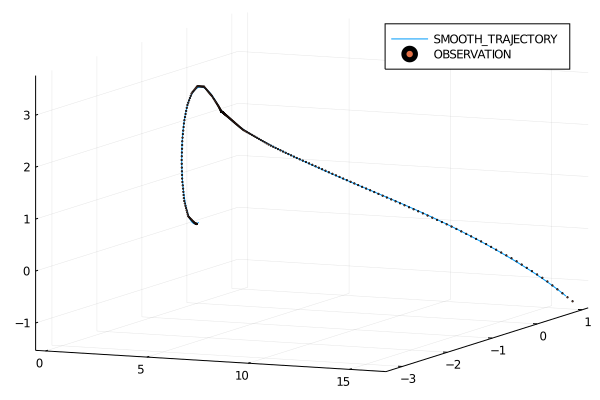

In [11]:
plt.plot(smooth_coordinates[:,1],smooth_coordinates[:,2],smooth_coordinates[:,3],label ="SMOOTH_TRAJECTORY")
plt.scatter!(new_coordinate[:,1],new_coordinate[:,2],new_coordinate[:,3],label ="OBSERVATION",markersize=1.0)

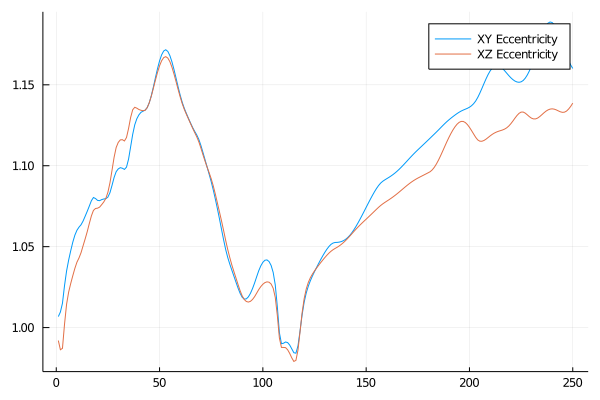

In [12]:
plt.plot(smooth_time,[xy_ecc xz_ecc],label=["XY Eccentricity" "XZ Eccentricity"])

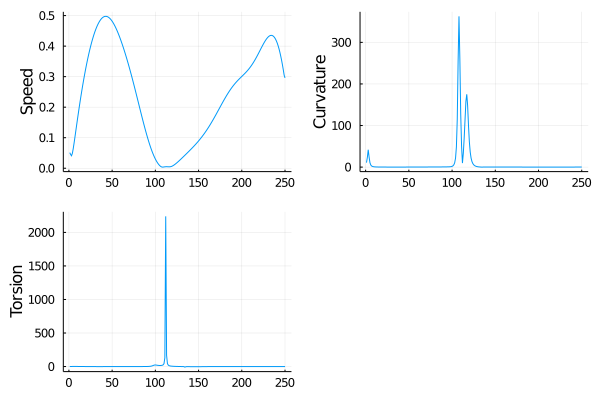

In [13]:
begin
	p1 = plt.plot(smooth_time,speed,ylabel = "Speed")
	p2 = plt.plot(smooth_time,curvature,ylabel = "Curvature",)
	p3 = plt.plot(smooth_time,torsion,ylabel="Torsion",)
	plt.plot(p1,p2,p3,legend=false)
end